In [39]:
# basic imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning imports
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, recall_score, precision_score, precision_recall_curve, average_precision_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# preprocessing imports
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

In [40]:
data1 = pd.read_csv('Virgin.csv')
data2 = pd.read_csv('Recycled.csv')
df = pd.concat([data1, data2])

df.head(5)

,Row,B3_DATUM_B_LOC,B3_REF_OD,C1_LOC_INSIDE_PLN,C4_LOC_TOP_PLN,B3_THICK1_WALL,B3_THICK2_WALL,B3_THICK3_WALL,B3_THICK4_WALL,Layout,BuildDate,Powder,MeasureSeq,Nonconformity,RowID,ColID,PlateID
0,Aa1,0.4176,0.4481,0.0545,0.2661,0.0158,0.0152,0.0153,0.0144,6X6,8/5/2019,Virgin,PreEDM,False,1,1,A
1,Aa3,0.4178,0.4483,0.0540,0.2663,0.0169,0.0154,0.0149,0.0151,6X6,8/5/2019,Virgin,PreEDM,False,1,3,A
2,Aa5,0.4176,0.4485,0.0539,0.2658,0.0155,0.0156,0.0144,0.0157,6X6,8/5/2019,Virgin,PreEDM,False,1,5,A
3,Aa7,0.4180,0.4480,0.0537,0.2655,0.0149,0.0149,0.0149,0.0152,6X6,8/5/2019,Virgin,PreEDM,False,1,7,A
4,Aa9,0.4176,0.4483,0.0531,0.2652,0.0184,0.0158,0.0159,0.0160,6X6,8/5/2019,Virgin,PreEDM,False,1,9,A


In [41]:
# Creating location variable
df['Location'] = df['Row'].str.lower().str.extract(r'([a-z]\d+)$', expand=False)

In [42]:
# Manually classifying parts as scrapped
scrap_condition = (((df['B3_DATUM_B_LOC'] <= 0.415) | (df['B3_DATUM_B_LOC'] >= 0.435)) 
   | ((df['B3_REF_OD'] <= 0.445) | (df['B3_REF_OD'] >= 0.469)) 
   | ((df['C1_LOC_INSIDE_PLN'] <= 0.049) | (df['C1_LOC_INSIDE_PLN'] >= 0.069)) 
   | ((df['C4_LOC_TOP_PLN'] <= 0.261) | (df['C4_LOC_TOP_PLN'] >= 0.281))
   | ((df['B3_THICK1_WALL'] <= 0.010) | (df['B3_THICK1_WALL'] >= 0.017))
   | ((df['B3_THICK2_WALL'] <= 0.010) | (df['B3_THICK2_WALL'] >= 0.017))
   | ((df['B3_THICK3_WALL'] <= 0.010) | (df['B3_THICK3_WALL'] >= 0.017))
   | ((df['B3_THICK4_WALL'] <= 0.010) | (df['B3_THICK4_WALL'] >= 0.017)))


In [43]:
df['scrap'] = scrap_condition.astype(int)

In [44]:
#Calculating the overall 'scrap rate'
scrap_rate = len(df[df['scrap'] == 1]) / len(df)
scrap_rate

0.21217948717948718

In [45]:
# Creating the zone conditions (edge,between,center)

edge_cond = df[(df.ColID == 1) | (df.RowID == 1) | (df.ColID == 11) | (df.RowID == 11)]

between_cond = df[(((df.ColID == 2) | (df.ColID == 3)) & ((df.RowID != 1) & (df.RowID != 11)))
              | (((df.ColID == 9) | (df.ColID == 10)) & ((df.RowID != 1) & (df.RowID != 11)))
              | (((df.RowID == 2) | (df.RowID == 3)) & ((df.ColID != 1) & (df.ColID != 11)))
              | (((df.RowID == 9) | (df.RowID == 10)) & ((df.ColID != 1) & (df.ColID != 11)))]

mask = ~df.apply(tuple,1).isin(pd.concat([edge_cond, between_cond]).apply(tuple,1))
center_cond = df[mask]

df["Location_norm"]         = df["Location"].str.strip().str.lower()
edge_cond["Location_norm"]  = edge_cond["Location"].str.strip().str.lower()
between_cond["Location_norm"]= between_cond["Location"].str.strip().str.lower()
center_cond["Location_norm"]= center_cond["Location"].str.strip().str.lower()

edge_set = set(edge_cond["Location"].astype(str).str.strip().str.lower().unique())
between_set = set(between_cond["Location"].astype(str).str.strip().str.lower().unique())
center_set = set(center_cond["Location"].astype(str).str.strip().str.lower().unique())  # optional

loc_norm = df["Location"].astype(str).str.strip().str.lower()

# labeling with priority: edge > between > center
df["Zone"] = "center"
df.loc[loc_norm.isin(between_set), "Zone"] = "between"
df.loc[loc_norm.isin(edge_set),    "Zone"] = "edge"    

#df[df.Zone == 'center']['Location'].unique()

C:\Users\bouka\AppData\Local\Temp\ipykernel_30160\4200668246.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edge_cond["Location_norm"]  = edge_cond["Location"].str.strip().str.lower()
C:\Users\bouka\AppData\Local\Temp\ipykernel_30160\4200668246.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  between_cond["Location_norm"]= between_cond["Location"].str.strip().str.lower()
C:\Users\bouka\AppData\Local\Temp\ipykernel_30160\4200668246.py:16: SettingWithCopyWarning: 
A value is trying to be set on a co

In [46]:
# Seperating features / target
X = df[['Layout', 'Powder', 'Zone']]
y = df['scrap']

# Splitting train/test data + stratify for consistency 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

categorical_features = ['Layout', 'Powder', 'Zone']

cat_pipe = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", dtype=np.int8)
)

preprocessor = make_column_transformer(
    (cat_pipe, categorical_features),
    remainder="drop"
)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


Best params: {'clf__subsample': 0.8, 'clf__reg_lambda': 1.0, 'clf__reg_alpha': 0.5, 'clf__n_estimators': 600, 'clf__max_depth': 3, 'clf__learning_rate': 0.03, 'clf__colsample_bytree': 0.85}
Chosen threshold: 0.41369188

=== Lowest predicted scrap (observed combos) ===


,Layout,Powder,Zone,p_scrap
0,6X6TA,Virgin,center,0.056874
1,6X6,Virgin,edge,0.213617
2,6X6TA,Virgin,between,0.266328
3,11X11TA,Virgin,center,0.266959
4,6X6,Virgin,between,0.278576
5,6X6TA,Virgin,edge,0.317793
6,11X11TA,Virgin,between,0.362525
7,6X6,Virgin,center,0.363001
8,11X11TA,Virgin,edge,0.413692
9,11X11TA,Recycled,center,0.478611


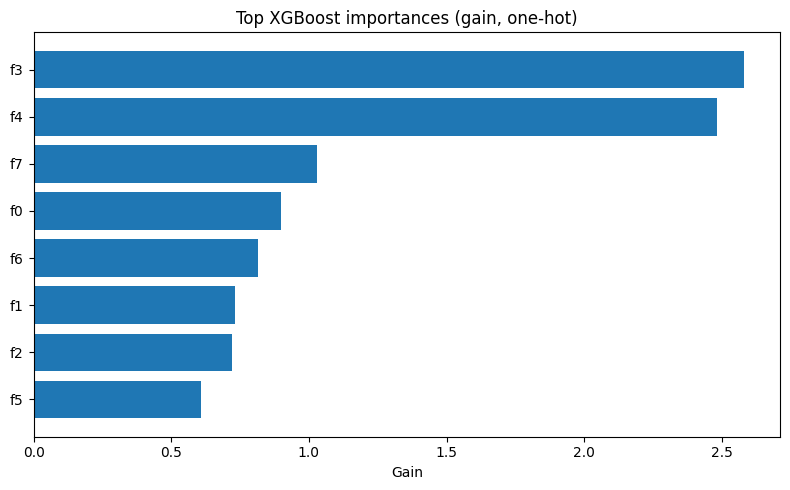

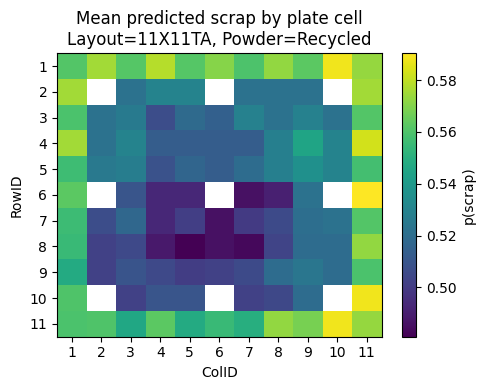

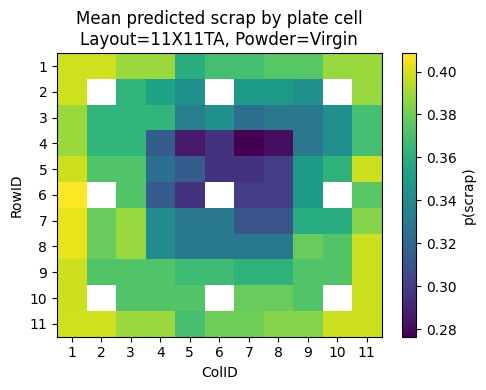

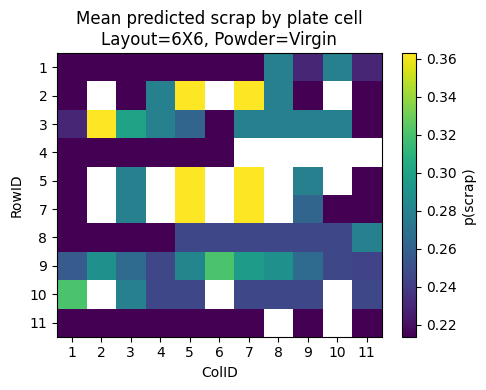

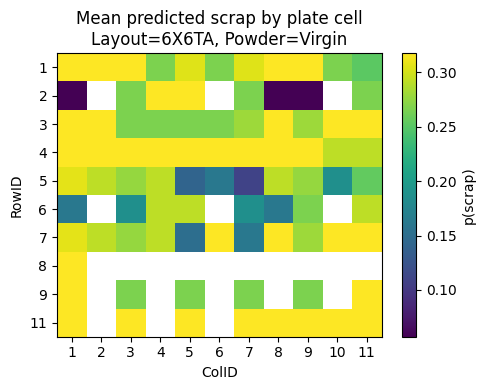


=== Recommended setups (lowest avg p(scrap)) ===


,Layout,Powder,Zone,p_scrap
0,6X6TA,Virgin,center,0.056874
1,6X6,Virgin,edge,0.213617
2,6X6TA,Virgin,between,0.266328
3,11X11TA,Virgin,center,0.266959
4,6X6,Virgin,between,0.278576
5,6X6TA,Virgin,edge,0.317793
6,11X11TA,Virgin,between,0.362525
7,6X6,Virgin,center,0.363001
8,11X11TA,Virgin,edge,0.413692
9,11X11TA,Recycled,center,0.478611


In [47]:
# Handling imbalance
pos = int((np.asarray(y) == 1).sum())
neg = int((np.asarray(y) == 0).sum())
scale_pos_weight = max(1, int(neg / max(1, pos)))

# Creating XGBoost model
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",
    tree_method="hist",
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    reg_alpha=0.0
)

pipe = Pipeline(steps=[
    ("pre", preprocessor),
    ("clf", xgb)
])

# parameter tuning
param_dist = {
    "clf__n_estimators": [300, 400, 600, 800],
    "clf__max_depth": [3, 4, 5, 6],
    "clf__learning_rate": [0.03, 0.05, 0.07, 0.1],
    "clf__subsample": [0.8, 0.9, 1.0],
    "clf__colsample_bytree": [0.7, 0.85, 1.0],
    "clf__reg_lambda": [0.5, 1.0, 2.0, 5.0],
    "clf__reg_alpha": [0.0, 0.5, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def pr_auc_scorer(estimator, Xval, yval):
    proba = estimator.predict_proba(Xval)[:, 1]
    return average_precision_score(yval, proba)

search = RandomizedSearchCV(
    pipe, param_distributions=param_dist, n_iter=40,
    scoring=pr_auc_scorer, cv=cv, random_state=42, n_jobs=-1, verbose=1
)
search.fit(X, y)

best_model = search.best_estimator_
#print("Best PR-AUC (cv):", search.best_score_)
print("Best params:", search.best_params_)

# Predict the scrap rate of the best performing model
best_model.fit(X, y)
p_scrap = best_model.predict_proba(X)[:, 1]

# Choose a threshold by best F1 score
prec, rec, thr = precision_recall_curve(y, p_scrap)
f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
idx = np.nanargmax(f1)
best_thr = thr[max(0, idx-1)]
print("Chosen threshold:", best_thr)
y_hat = (p_scrap >= best_thr).astype(int)
#print("In-sample F1:", f1[idx])


# Rank *observed* combinations by mean predicted scrap
df_pred = df[categorical_features].copy()
df_pred["p_scrap"] = p_scrap

rank_cols = [c for c in ["Layout","Powder","Zone"] if c in df_pred.columns]
agg = (df_pred.groupby(rank_cols, dropna=False)["p_scrap"]
             .mean()
             .sort_values(ascending=True)
             .reset_index())

print("\n=== Lowest predicted scrap (observed combos) ===")
display(agg.head(20))

# Global feature importance on one-hot columns
xgb_fitted = best_model.named_steps["clf"]
imp = xgb_fitted.get_booster().get_score(importance_type="gain")
imp_series = pd.Series(imp).sort_values(ascending=False)

plt.figure(figsize=(8,5))
topk = 20 if len(imp_series) > 20 else len(imp_series)
plt.barh(list(imp_series.index[:topk])[::-1], list(imp_series.values[:topk])[::-1])
plt.title("Top XGBoost importances (gain, one-hot)")
plt.xlabel("Gain")
plt.tight_layout()
plt.show()

# Aggregate importance back to original features (Layout vs Powder vs Location)
def root_name(s):
    for key in categorical_features:
        if key in s:
            return key
    return "other"

imp_df = pd.DataFrame({"feature": imp_series.index, "gain": imp_series.values})
imp_df["root"] = imp_df["feature"].apply(root_name)
root_imp = imp_df.groupby("root")["gain"].sum().sort_values(ascending=False)

# Plate visualization
has_grid = {"RowID": "RowID" in df.columns, "ColID": "ColID" in df.columns}
if all(has_grid.values()):
    df_plate = df_pred.copy()
    # merge the grid columns from df
    df_plate = df_plate.merge(df[["RowID","ColID"]], left_index=True, right_index=True)

    combos = df_plate.groupby(["Layout","Powder"]).size().reset_index()[["Layout","Powder"]].values
    max_plots = 4  # adjust if you want more
    for ly, pw in combos[:max_plots]:
        sub = df_plate[(df_plate["Layout"]==ly) & (df_plate["Powder"]==pw)]
        pivot = pd.pivot_table(sub, index="RowID", columns="ColID", values="p_scrap", aggfunc="mean")
        plt.figure(figsize=(5,4))
        plt.imshow(pivot.values.astype(float), aspect="auto")
        plt.xticks(range(pivot.shape[1]), list(pivot.columns))
        plt.yticks(range(pivot.shape[0]), list(pivot.index))
        plt.title(f"Mean predicted scrap by plate cell\nLayout={ly}, Powder={pw}")
        plt.xlabel("ColID")
        plt.ylabel("RowID")
        plt.colorbar(label="p(scrap)")
        plt.tight_layout()
        plt.show()
else:
    # Bar chart of p_scrap by Location (lowest to highest)
    if "Location" in df_pred.columns:
        loc_avg = (df_pred.groupby(["Layout","Powder","Zone"])["p_scrap"]
                          .mean()
                          .reset_index()
                          .sort_values("p_scrap", ascending=True))
        top_n = loc_avg.head(30)
        plt.figure(figsize=(10,6))
        labels = (top_n["Layout"]+"|"+top_n["Powder"]+"|"+top_n["Zone"]).tolist()
        plt.barh(labels[::-1], top_n["p_scrap"].values[::-1])
        plt.title("Lowest predicted scrap by (Layout|Powder|Zone)")
        plt.xlabel("p(scrap)")
        plt.tight_layout()
        plt.show()


setup_cols = [c for c in ["Layout","Powder", "Zone"] if c in df_pred.columns]
if setup_cols:
    rec = (df_pred.groupby(setup_cols)["p_scrap"]
                  .mean()
                  .sort_values()
                  .reset_index())
    print("\n=== Recommended setups (lowest avg p(scrap)) ===")
    display(rec.head(10))

In [48]:
# Count the number of rows/samples for each different configuration
n_rows = (df_pred.groupby(rank_cols)
                  .size()
                  .reset_index(name="n_rows"))

agg = (agg
       .merge(n_rows, on=rank_cols, how="left"))

# How many unique combos for each PlateID?
if "PlateID" in df.columns:
    # unique PlateIDs per (Layout, Powder, Zone)
    count_keys = [c for c in rank_cols]  
    n_plates = (df.loc[df_pred.index, :]   
                  .groupby(count_keys)["PlateID"]
                  .nunique()
                  .reset_index()
                  .rename(columns={"PlateID":"n_plates"}))
    agg = agg.merge(n_plates, on=count_keys, how="left")

rec_n_rows = (df_pred.groupby(setup_cols)
                       .size()
                       .reset_index(name="n_rows"))
rec = rec.merge(rec_n_rows, on=setup_cols, how="left")

if "PlateID" in df.columns:
    rec_count_keys = [c for c in setup_cols]  
    rec_n_plates = (df.loc[df_pred.index, :]
                      .groupby(rec_count_keys)["PlateID"]
                      .nunique()
                      .reset_index()
                      .rename(columns={"PlateID":"n_plates"}))
    rec = rec.merge(rec_n_plates, on=rec_count_keys, how="left")

rec.head(10)

,Layout,Powder,Zone,p_scrap,n_rows,n_plates
0,6X6TA,Virgin,center,0.056874,12,3
1,6X6,Virgin,edge,0.213617,60,3
2,6X6TA,Virgin,between,0.266328,36,3
3,11X11TA,Virgin,center,0.266959,120,5
4,6X6,Virgin,between,0.278576,36,3
5,6X6TA,Virgin,edge,0.317793,60,3
6,11X11TA,Virgin,between,0.362525,240,5
7,6X6,Virgin,center,0.363001,12,3
8,11X11TA,Virgin,edge,0.413692,200,5
9,11X11TA,Recycled,center,0.478611,168,7


In [49]:
# Top configuration with minimum possible scrap rate (~5.7%)
rec.head(1)

,Layout,Powder,Zone,p_scrap,n_rows,n_plates
0,6X6TA,Virgin,center,0.056874,12,3


In [50]:
#Calculating the overall 'scrap rate'
scrap_rate = len(df[df['scrap'] == 1]) / len(df)
lowest_scrap = rec['p_scrap'][0]

print("Original Scrap Rate: " + str(scrap_rate))
print("Lowest Scrap Rate: " + str(lowest_scrap))
print("Lowered scrap rate by ~15.5%")

Original Scrap Rate: 0.21217948717948718
Lowest Scrap Rate: 0.056874078
Lowered scrap rate by ~15.5%
